# EDA

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

SEED = 53188535

## There are three potential datasets for this project:

### ~9k Myers-Briggs Personality Type labeled comments from PersonalityCafe

In [30]:
cafe_df = pd.read_csv('data/mbti_1.csv')

In [31]:
cafe_df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


### ~100k Myers-Briggs Personality Type labeled comments from PersonalityCafe and Google Big Query Reddit users. 
Posts are preprocessed texts:

- No punctuations, stopwords, URLs
- Lemmatization
- Reconstruct samples to be equal-sized chunks (500 words per sample)

In [32]:
both_df = pd.read_csv('data/MBTI 500.csv')

### ~1.7M Google Big Query of Reddit comments and their Myers-Briggs Personality Type

In [33]:
gbq_df = pd.read_csv('data/mbti_full_pull.csv')

In [34]:
whitelist = ['intp', 'intj', 'entp', 'entj', 'infj', 'infp', 'enfj', 'enfp', 'istj', 'isfj', 'estj', 'esfj', 'istp', 'isfp', 'estp', 'esfp']

In [35]:
set(''.join(whitelist))

{'e', 'f', 'i', 'j', 'n', 'p', 's', 't'}

## Personality Cafe
For the baseline, will use the Peronality Cafe Data.

In [36]:
# Creating list of all the variables for Myers_Briggs type for future use.
pred_lst = ['intp', 'intj', 'entp', 'entj', 'infj', 'infp', 'enfj', \
    'enfp', 'istj', 'isfj', 'estj', 'esfj', 'istp', 'isfp', 'estp', 'esfp']

pred_st = set(''.join(pred_lst))

In [37]:
cafe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [38]:
cafe_df.type.value_counts(normalize=True)

INFP    0.211182
INFJ    0.169452
INTP    0.150317
INTJ    0.125764
ENTP    0.078963
ENFP    0.077810
ISTP    0.038847
ISFP    0.031239
ENTJ    0.026628
ISTJ    0.023631
ENFJ    0.021902
ISFJ    0.019135
ESTP    0.010259
ESFP    0.005533
ESFJ    0.004841
ESTJ    0.004496
Name: type, dtype: float64

### Clean & Preprocess

In [39]:
cafe_clean = cafe_df.copy()

In [40]:
import re
import string

In [41]:
punc = string.punctuation

In [42]:
cafe_clean['type'] = cafe_clean.type.str.lower()

In [43]:
cafe_clean['clean_posts'] = cafe_clean.posts.str.lower()

In [44]:
test = [1,2,3]

In [45]:
range(len(test))

range(0, 3)

In [46]:
def url_remove(post):
    return re.sub(r'http\S+', '', post)

def pipe_remove(post):
    return re.sub(r'[|]', ' ', post)

def punc_remove(post):
    return re.sub(r'[\'_:]', '', post)

def remove_dig_token(post):
    return [post[i] for i in range(len(post)) if post[i].isalpha()]

def remove_stopwords(post):
    sw = stopwords.words('english')
    return [post[i] for i in range(len(post)) if post[i] not in sw]

In [47]:
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(pipe_remove)

In [48]:
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(url_remove)

In [49]:
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(punc_remove)

In [50]:
cafe_clean.iloc[2, 2]

'good one        of course, to which i say i know; thats my blessing and my curse.   does being absolutely positive that you and your best friend could be an amazing couple count? if so, than yes.   or its more i could be madly in love in case i reconciled my feelings (which at...   no, i didnt; thank you for a link!   so-called ti-si loop (and it can stem from any current topic/obsession) can be deadly. its like when youre stuck in your own thoughts, and your mind just wanders in circles. feels truly terrible. ...   have you noticed how peculiar vegetation can be? all you have to do is look down at the grass dozens of different plant species there.    and now imagine that hundreds of years later (when/if soil...   the smiths – never had no one ever   i often find myself spotting faces on marble tiles/wood.   this 5 year-old sentence is an incredibly accurate and beautiful description.   i havent visited this website in the last 3 years. so whoever reads this (and maybe even remembers 

In [51]:
pattern = r"(?u)\b\w\w+\b"

In [52]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(pattern)

In [53]:
cafe_clean['post_token'] = cafe_clean['clean_posts'].apply(tokenizer.tokenize)

In [54]:
cafe_clean['post_token'] = cafe_clean['post_token'].apply(remove_dig_token)

In [55]:
cafe_clean['post_token'] = cafe_clean['post_token'].apply(remove_stopwords)

In [56]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(w) for w in tokens]

In [57]:
cafe_clean['post_token'] = cafe_clean['post_token'].apply(lemmatize_text)

In [58]:
def join_tokens(tokens):
    long_string = ' '.join(tokens)
    return long_string

In [59]:
cafe_clean['token_joined'] = cafe_clean['post_token'].apply(join_tokens)

In [60]:
cafe_clean['clean_posts'] = cafe_clean['post_token'].str.join(' ')

In [61]:
cafe_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   type          8675 non-null   object
 1   posts         8675 non-null   object
 2   clean_posts   8675 non-null   object
 3   post_token    8675 non-null   object
 4   token_joined  8675 non-null   object
dtypes: object(5)
memory usage: 339.0+ KB


In [62]:
cafe_clean.head(5)

,type,posts,clean_posts,post_token,token_joined
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp intj moment sportscenter top ten play pra...,"[enfp, intj, moment, sportscenter, top, ten, p...",enfp intj moment sportscenter top ten play pra...
1,entp,'I'm finding the lack of me in these posts ver...,im finding lack post alarming sex boring posit...,"[im, finding, lack, post, alarming, sex, borin...",im finding lack post alarming sex boring posit...
2,intp,'Good one _____ https://www.youtube.com/wat...,good one course say know thats blessing curse ...,"[good, one, course, say, know, thats, blessing...",good one course say know thats blessing curse ...
3,intj,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoyed conversation day esoteric ga...,"[dear, intp, enjoyed, conversation, day, esote...",dear intp enjoyed conversation day esoteric ga...
4,entj,'You're fired.|||That's another silly misconce...,youre fired thats another silly misconception ...,"[youre, fired, thats, another, silly, misconce...",youre fired thats another silly misconception ...


### Adding binary targets

In [63]:
cafe_clean['i/e'] = cafe_clean['type'].map(lambda x: x[0])
cafe_clean['n/s'] = cafe_clean['type'].map(lambda x: x[1])
cafe_clean['t/f'] = cafe_clean['type'].map(lambda x: x[2])
cafe_clean['p/j'] = cafe_clean['type'].map(lambda x: x[3])


In [94]:
print(cafe_clean['i/e'].value_counts())
print(cafe_clean['n/s'].value_counts())
print(cafe_clean['t/f'].value_counts())
print(cafe_clean['p/j'].value_counts())

i    6676
e    1999
Name: i/e, dtype: int64
n    7478
s    1197
Name: n/s, dtype: int64
f    4694
t    3981
Name: t/f, dtype: int64
p    5241
j    3434
Name: p/j, dtype: int64


In [64]:
cafe_clean

,type,posts,clean_posts,post_token,token_joined,i/e,n/s,t/f,p/j
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp intj moment sportscenter top ten play pra...,"[enfp, intj, moment, sportscenter, top, ten, p...",enfp intj moment sportscenter top ten play pra...,i,n,f,j
1,entp,'I'm finding the lack of me in these posts ver...,im finding lack post alarming sex boring posit...,"[im, finding, lack, post, alarming, sex, borin...",im finding lack post alarming sex boring posit...,e,n,t,p
2,intp,'Good one _____ https://www.youtube.com/wat...,good one course say know thats blessing curse ...,"[good, one, course, say, know, thats, blessing...",good one course say know thats blessing curse ...,i,n,t,p
3,intj,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoyed conversation day esoteric ga...,"[dear, intp, enjoyed, conversation, day, esote...",dear intp enjoyed conversation day esoteric ga...,i,n,t,j
4,entj,'You're fired.|||That's another silly misconce...,youre fired thats another silly misconception ...,"[youre, fired, thats, another, silly, misconce...",youre fired thats another silly misconception ...,e,n,t,j
...,...,...,...,...,...,...,...,...,...
8670,isfp,'https://www.youtube.com/watch?v=t8edHB_h908||...,ixfp always think cat fi doms reason especiall...,"[ixfp, always, think, cat, fi, doms, reason, e...",ixfp always think cat fi doms reason especiall...,i,s,f,p
8671,enfp,'So...if this thread already exists someplace ...,thread already exists someplace else heck dele...,"[thread, already, exists, someplace, else, hec...",thread already exists someplace else heck dele...,e,n,f,p
8672,intp,'So many questions when i do these things. I ...,many question thing would take purple pill pic...,"[many, question, thing, would, take, purple, p...",many question thing would take purple pill pic...,i,n,t,p
8673,infp,'I am very conflicted right now when it comes ...,conflicted right come wanting child honestly m...,"[conflicted, right, come, wanting, child, hone...",conflicted right come wanting child honestly m...,i,n,f,p


### Baseline Models

In [65]:
X = cafe_clean['token_joined']
y = cafe_clean['i/e']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [66]:
count_vc = CountVectorizer(ngram_range=(1,2))

In [67]:
X_train_count = count_vc.fit_transform(X_train)
X_test_count = count_vc.transform(X_test)

In [68]:
sgd = SGDClassifier(class_weight='balanced', random_state=SEED)

sgd.fit(X_train_count, y_train)

cv_score = cross_val_score(sgd, X_train_count, y_train, cv=5)
cv_score_mean = round(np.mean(cv_score), 4)

y_pred = sgd.predict(X_test_count)
acc_score = accuracy_score(y_pred, y_test)

print(f"CV: {cv_score_mean}, A: {acc_score}")

CV: 0.8411, A: 0.8501613646841862


In [69]:
y_test.value_counts(normalize=True)

i    0.788843
e    0.211157
Name: i/e, dtype: float64

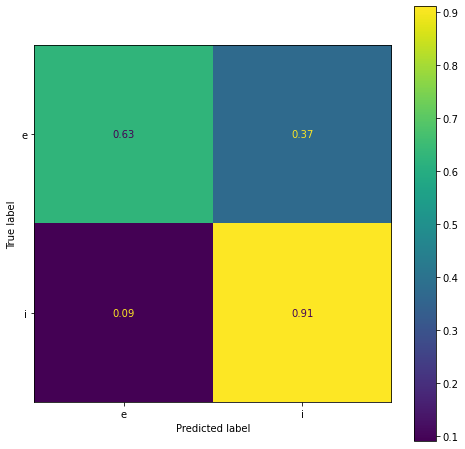

In [70]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(sgd, X_test_count, y_test, ax=ax, normalize='true')

In [71]:
# BASELINE
# ---------
# All classes ~60%
# i/e ~85%
# n/s ~90%
# p/j ~77%
# t/f ~85%

### Understample test set for binary

In [72]:
from imblearn.under_sampling import RandomUnderSampler

In [73]:
train_set, test_set = train_test_split(cafe_clean, random_state=SEED)

X_train = train_set['token_joined']
X_train = np.array(X_train).reshape(-1, 1)

y_train = train_set['t/f']
y_train = np.array(y_train).reshape(-1, 1)


# instantiating the random undersampler
rus = RandomUnderSampler() 

# resampling training set X & y
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# new class distribution
print(np.unique(y_train, return_counts=True))
print(np.unique(y_rus, return_counts=True))

(array(['f', 't'], dtype=object), array([3544, 2962]))
(array(['f', 't'], dtype=object), array([2962, 2962]))


In [74]:
X_rus.reshape(-1).shape

(5924,)

In [75]:
X_rus = pd.Series(X_rus.reshape(-1))
y_rus = pd.Series(y_rus.reshape(-1))

In [76]:
X_train_count = count_vc.fit_transform(X_rus)
X_test_count = count_vc.transform(test_set['token_joined'])

In [77]:
sgd = SGDClassifier(class_weight='balanced', random_state=SEED)

sgd.fit(X_train_count, y_rus)

cv_score = cross_val_score(sgd, X_train_count, y_rus, cv=5)
cv_score_mean = round(np.mean(cv_score), 4)

y_pred = sgd.predict(X_test_count)
acc_score = accuracy_score(y_pred, test_set['t/f'])

print(f"CV: {cv_score_mean}, A: {acc_score}")

CV: 0.8331, A: 0.8386353158137391


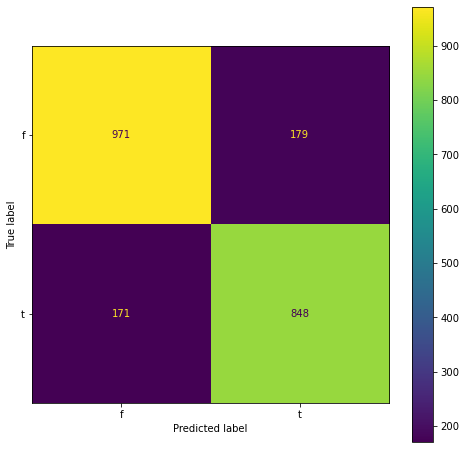

In [78]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(sgd, X_test_count, test_set['t/f'], ax=ax)

In [79]:
# Undersampling
# ---------
# i/e ~81%
# n/s ~83%
# p/j ~76%
# t/f ~83%

## Both DF

Comparing baseline models to this other dataset

In [86]:
both_clean = both_df.copy()

In [87]:
both_clean['type'] = both_clean['type'].str.lower()

In [90]:
both_clean['type'].value_counts()

intp    24961
intj    22427
infj    14963
infp    12134
entp    11725
enfp     6167
istp     3424
entj     2955
estp     1986
enfj     1534
istj     1243
isfp      875
isfj      650
estj      482
esfp      360
esfj      181
Name: type, dtype: int64

In [91]:
both_clean['i/e'] = both_clean['type'].map(lambda x: x[0])
both_clean['n/s'] = both_clean['type'].map(lambda x: x[1])
both_clean['t/f'] = both_clean['type'].map(lambda x: x[2])
both_clean['p/j'] = both_clean['type'].map(lambda x: x[3])


In [93]:
print(both_clean['i/e'].value_counts())
print(both_clean['n/s'].value_counts())
print(both_clean['t/f'].value_counts())
print(both_clean['p/j'].value_counts())

i    80677
e    25390
Name: i/e, dtype: int64
n    96866
s     9201
Name: n/s, dtype: int64
t    69203
f    36864
Name: t/f, dtype: int64
p    61632
j    44435
Name: p/j, dtype: int64


In [95]:
both_clean.columns

Index(['posts', 'type', 'i/e', 'n/s', 't/f', 'p/j'], dtype='object')

In [126]:
X = both_clean['posts']
y = both_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [127]:
count_vc = CountVectorizer(ngram_range=(1,2))

In [128]:
X_train_count = count_vc.fit_transform(X_train)
X_test_count = count_vc.transform(X_test)

In [129]:
sgd = SGDClassifier(class_weight='balanced', random_state=SEED)

sgd.fit(X_train_count, y_train)

cv_score = cross_val_score(sgd, X_train_count, y_train, cv=5)
cv_score_mean = round(np.mean(cv_score), 4)

y_pred = sgd.predict(X_test_count)
acc_score = accuracy_score(y_pred, y_test)

print(f"CV: {cv_score_mean}, A: {round(acc_score, 4)}")

CV: 0.9213, A: 0.9251


In [130]:
y_test.value_counts(normalize=True)

t    0.653204
f    0.346796
Name: t/f, dtype: float64

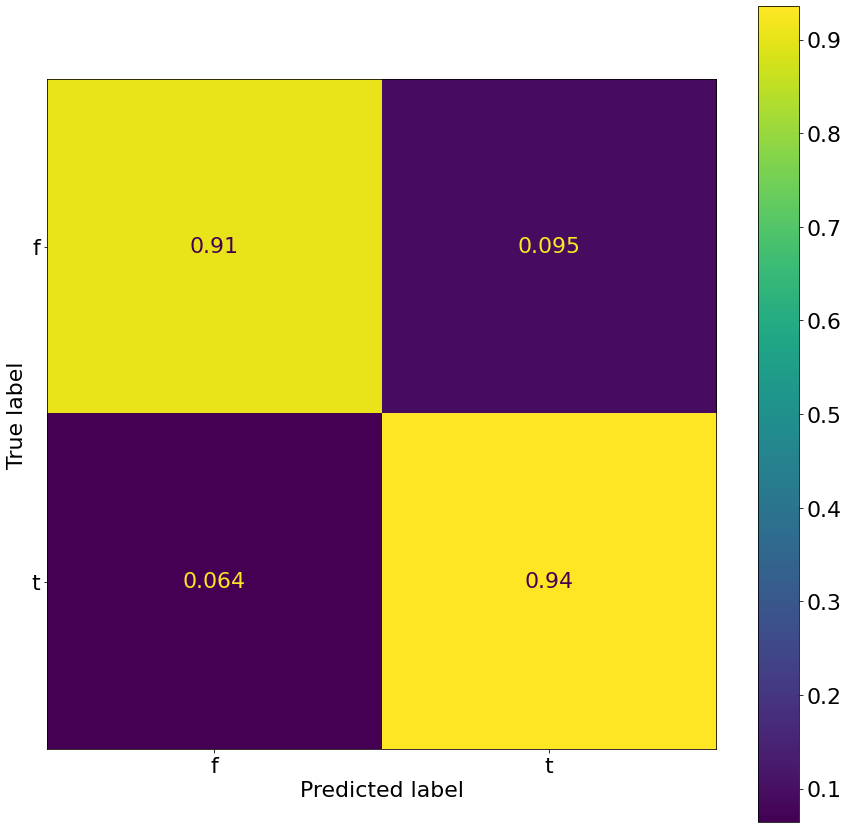

In [135]:
fig, ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22) 
plot_confusion_matrix(sgd, X_test_count, y_test, ax=ax, normalize='true')

In [ ]:
# BASELINE (100k set)
# ---------
# All ~82%
# i/e ~85%
# n/s ~96%
# p/j ~86%
# t/f ~92%

# BASELINE (Cafe 9k set)
# ---------
# All classes ~60%
# i/e ~85%
# n/s ~90%
# p/j ~77%
# t/f ~85%

# Undersampling (Cafe)
# ---------
# i/e ~81%
# n/s ~83%
# p/j ~76%
# t/f ~83%



In [111]:
set(gbq_df['author_flair_text'])

{'INTP / 30 / Male',
 "INTJ/ENTJ I don't fucking know",
 'Big 5" ISTPenises',
 'INTJ | 21M',
 'INFP: The beautiful contradiction of nonsense',
 'INTJ: The Paradox',
 'INFJ/F/32',
 'ENTP \\\\ type me',
 'North Rhine-Westphalia / European Union',
 'infj/f/24/6w2',
 '25F // INTJ',
 'INFP 4w5: Longing for something.',
 "INFP: It's an abstract kind of feel",
 'INFP: The Dreamer | 2w7',
 'JustaninnocentPony',
 'ENTP 24M',
 'ESFP 6w5 SX/SO',
 'INTP-ILI; 5w4',
 'INFP: Son of Starlight',
 'INFP/M/22',
 'INFPeanut',
 'ENTP/32/F/9w1',
 'F19 ISTP volcel',
 'INFP: The Quiet One',
 '23F | INFJ',
 'ISFP: The Cloudcuckoolander E9',
 'ENTP: The Mad Scientist',
 '26 M ENTP',
 'Borderline INTP/INFP',
 'INTP Jungler',
 'INTP | F | 17',
 'Super Class Type ENTP Mk 7w8',
 'INFJ, M, 20',
 'eNTP',
 'infj / NT fangirl',
 '22, femake, INFJ',
 'INFP: That is me',
 'INFP: The Apparently Dualistic Face',
 'M/18/INFJ-T',
 'infj/m/28',
 'DampestParsley9',
 'infp 4w5 sp/so',
 '27/F/infj',
 'infp 9w8: child of Earth',
